<a href="https://colab.research.google.com/github/nickchang001/Candidate-Generation-and-Movie-Recommendation/blob/main/Candidate_Generation_and_Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Movie Recommendation System
####Motivation and Business Impact:

*    Increase users engagement
 1. Increase time spent on website.
 2. Increase number of movie wathched.

*   Increase website Revenue.

####Outline


*   Data ETL: Build an data  pipeline using Pyspark.
*   Exploration: Preprocess and visullize data with Spark DataFrame and seaborn.
*   Model: 
  1. Train an ALS model and use Spark ML cross-validatoin to fine tune hyper parameters.
  2. Word2Vec embedding.
  3. User Tag embedding
*   Serving: 
  1. Provide personalized movie recommendations without user has been watched before
  2. handel cold start issues with recommend top rating movies.





##Part 1: Environment Setup and Load Data

###Part 1.1: Set up Pyspark in colab

In [ ]:
#import nessary packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#install Pyspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#check the last version https://downloads.apache.org/spark/
!wget -q http://apache.forsale.plus/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz

!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!wget -q http://apache.mirrors.pair.com/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa

In [ ]:
# Set up Spark
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init("spark-3.0.2-bin-hadoop2.7")

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 204kB 5.4MB/s 
/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory



### Part1.2: Built ETL Pipeline

**Load and Cache**

Rather than read it over and over again from DBFS, we'll cache both the movies DataFrame and the ratings DataFrame in memory.

In [ ]:
#load data from machine to colab
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving links.csv to links.csv
Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv
Saving README.txt to README.txt
Saving tags.csv to tags.csv
User uploaded file "links.csv" with length 197979 bytes
User uploaded file "movies.csv" with length 494431 bytes
User uploaded file "ratings.csv" with length 2483723 bytes
User uploaded file "README.txt" with length 8342 bytes
User uploaded file "tags.csv" with length 118660 bytes


In [ ]:
#checking for loading
!ls

drive	    ratings.csv  spark-3.0.2-bin-hadoop2.7	  tags.csv
links.csv   README.txt	 spark-3.0.2-bin-hadoop2.7.tgz
movies.csv  sample_data  spark-3.0.2-bin-hadoop2.7.tgz.1


In [ ]:
#Load data into spark cluster as spark Dadaframe
movies_df = spark.read.load("movies.csv", format='csv', header = True)
ratings_df = spark.read.load("ratings.csv", format='csv', header = True)
tags_df = spark.read.load("tags.csv", format='csv', header=True)
links_df = spark.read.load("links.csv", format='csv', header=True)

#cache movie datafram and rating datafram in memory
movies_df.cache()
ratings_df.cache()

DataFrame[userId: string, movieId: string, rating: string, timestamp: string]

In [ ]:
#uninstall pyarrow and install it latter inorder to fix the issue of importing koalas
!pip uninstall pyarrow

Uninstalling pyarrow-3.0.0:
  Would remove:
    /usr/local/bin/plasma_store
    /usr/local/lib/python3.7/dist-packages/pyarrow-3.0.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pyarrow/*
Proceed (y/n)? y
  Successfully uninstalled pyarrow-3.0.0


In [ ]:
#install Koalas
!pip install koalas

# Install compatible version of pyarrow
!pip install pyarrow

#import koalas package
import databricks.koalas as ks

#load data as Koalas Dataframe, instead of convert from spark data frame b/c the columns are missing if we covert.
movies_kdf = ks.read_csv('movies.csv')
ratings_kdf = ks.read_csv('ratings.csv')
tags_kdf = ks.read_csv('tags.csv')
links_kdf = ks.read_csv('links.csv')

     |████████████████████████████████| 675kB 4.2MB/s 
     |████████████████████████████████| 20.7MB 1.3MB/s 


#Part2: Exploratory Data Analysis (EDA)

##Part2_1:Take a glance at data

In [ ]:
movies_kdf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings_kdf.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
tags_kdf.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


##Part2_2:Get some information about numerical features

In [ ]:
ratings_kdf.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.018535e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8092.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


**Notes: Minimun rating score is 0.5 and about 3/4 of users gave 3 or above rating score.

##Part2_3:Check missing values, size and data type

In [ ]:
movies_kdf.info()
#ratings_kdf.info()
#tags_kdf.info()

databricks.koalas.frame.DataFrame
Index: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int32 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int32(1), object(2)

##Part2_4:Checking distinct users, movies and tag

In [ ]:
print('Total number of distinct users:{} (out of totoal users:{}).'.format(ratings_kdf['userId'].unique().count(),ratings_kdf.shape[0]))
print('Total number of distinct movies:{} (out of total movies:{}).'.format(movies_kdf['title'].unique().count(),movies_kdf.shape[0]))
print('Total number of distinct tag:{} (out of total tags:{}).'.format(tags_kdf['tag'].unique().count(),tags_kdf.shape[0]))
print('Total number of ratings:{}'.format(ratings_kdf.shape[0]))

Total number of distinct users:610 (out of totoal users:100836).
Total number of distinct movies:9737 (out of total movies:9742).
Total number of distinct tag:1589 (out of total tags:3683).
Total number of ratings:100836


In [ ]:
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user: {}'.format(ratings_kdf.groupby('userId').count()['rating'].min()))
print('Minimum number of ratings per movie: {}'.format(ratings_kdf.groupby('movieId').count()['rating'].min()))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user: 20
Minimum number of ratings per movie: 1


In [ ]:
tmp1 = ratings_kdf.groupby('movieId').count()['rating']==1
tmp1_1 = tmp1.sum()
tmp2 = ratings_kdf['movieId'].unique().count()
print('There are {} out of {} movies ({:.2f}%) are rated by only one user.'.format(tmp1_1, tmp2, tmp1_1/tmp2*100) )

There are 3446 out of 9724 movies (35.44%) are rated by only one user.


**Notes: About 1/3 of movies has only one rating and each user rated at lease 20 mivies.

##Part2_5: Movie Genres

In [ ]:
#list all genres
genres_list = movies_df.select('genres').rdd.flatMap(lambda x: x['genres'].split('|')).distinct().collect()
print('List of genres:')
genres_list

List of genres:


['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql import Row

#replace missing value of genres with Nan
movies_df = movies_df.withColumn('genres', regexp_replace('genres', '(no genres listed)', 'Nan'))
genres_df = movies_df.select('genres').rdd.flatMap(lambda x: x['genres'].split('|')).map(lambda x: Row(genres=x)).toDF()
genres_cnt = genres_df.groupBy('genres').count().orderBy('count', ascending=False)
print('Number of movies in each genre:')
genres_cnt.show()

Number of movies in each genre:
+-----------+-----+
|     genres|count|
+-----------+-----+
|      Drama| 4361|
|     Comedy| 3756|
|   Thriller| 1894|
|     Action| 1828|
|    Romance| 1596|
|  Adventure| 1263|
|      Crime| 1199|
|     Sci-Fi|  980|
|     Horror|  978|
|    Fantasy|  779|
|   Children|  664|
|  Animation|  611|
|    Mystery|  573|
|Documentary|  440|
|        War|  382|
|    Musical|  334|
|    Western|  167|
|       IMAX|  158|
|  Film-Noir|   87|
|      (Nan)|   34|
+-----------+-----+



**Note: There are 19 of genres and few movies' genre is missing. Drama and Comdedy are most common genres.

##Part2_6: Ratings

**Ratings per User**

In [ ]:
#count number of ratings that each user gave
rating_user_pdf = ratings_df.groupBy('userid').count().orderBy('count', ascending=True).select('userid', col('count').alias('num_ratings')).toPandas()
rating_user_pdf.head(10)

,userid,num_ratings
0,442,20
1,595,20
2,406,20
3,320,20
4,147,20
5,207,20
6,257,20
7,194,20
8,189,20
9,53,20


**Distribution of number of Ratings each movie**

In [ ]:
dist_raings_pdf = rating_user_pdf.groupby(by='num_ratings').count().reset_index().rename(columns={'userid': 'num_users'}).sort_values(by=['num_ratings'], ascending=False)
dist_raings_pdf.head(10) 

,num_ratings,num_users
260,2698,1
259,2478,1
258,2108,1
257,1864,1
256,1346,1
255,1302,1
254,1260,1
253,1218,1
252,1115,1
251,1055,1


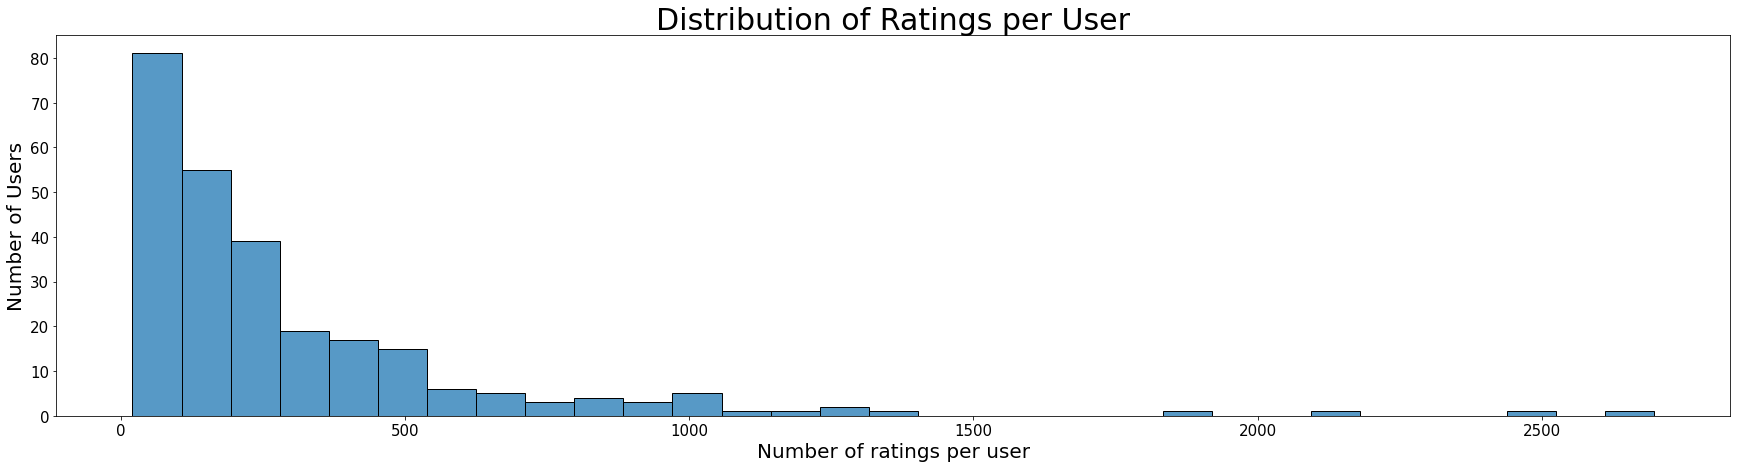

In [ ]:
#Visualize the distribution of ratings per user
fig = plt.figure(figsize=(30,7))
ax = fig.add_subplot(111)
sns.histplot(dist_raings_pdf, x='num_ratings')
ax.set_xlabel('Number of ratings per user', fontsize=20)
ax.set_ylabel('Number of Users', fontsize=20)
ax.set_title('Distribution of Ratings per User', fontsize=30)
ax.tick_params(labelsize=15)

**Notes: Most of user gave about ratings. A few user gave more than 1000 of ratings.

**Number of movies each rating score**

In [ ]:
#Join movie dataframe and rating dataframe 
movies_ratings_df = movies_df.join(ratings_df, on='movieId', how='left')
movies_ratings_df.show()

+-------+----------------+--------------------+------+------+----------+
|movieId|           title|              genres|userId|rating| timestamp|
+-------+----------------+--------------------+------+------+----------+
|      1|Toy Story (1995)|Adventure|Animati...|   610|   5.0|1479542900|
|      1|Toy Story (1995)|Adventure|Animati...|   609|   3.0| 847221025|
|      1|Toy Story (1995)|Adventure|Animati...|   608|   2.5|1117408267|
|      1|Toy Story (1995)|Adventure|Animati...|   607|   4.0| 964744033|
|      1|Toy Story (1995)|Adventure|Animati...|   606|   2.5|1349082950|
|      1|Toy Story (1995)|Adventure|Animati...|   605|   4.0|1277097561|
|      1|Toy Story (1995)|Adventure|Animati...|   604|   3.0| 832079851|
|      1|Toy Story (1995)|Adventure|Animati...|   603|   4.0| 963178147|
|      1|Toy Story (1995)|Adventure|Animati...|   601|   4.0|1521467801|
|      1|Toy Story (1995)|Adventure|Animati...|   600|   2.5|1237764347|
|      1|Toy Story (1995)|Adventure|Animati...|   5

In [ ]:
#count different rating score
num_ratings_movie_df = movies_ratings_df.groupBy('rating').count().orderBy('rating', acsending=True).toPandas()
num_ratings_movie_df.head()

,rating,count
0,None,18
1,0.5,1370
2,1.0,2811
3,1.5,1791
4,2.0,7551


Text(0.5, 1.0, 'Distribution of Ratings')

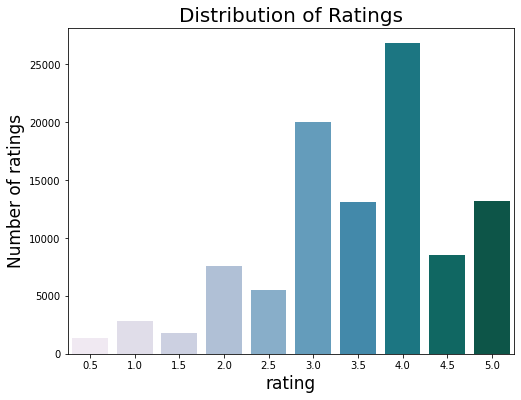

In [ ]:
#convert ratings from spar DF to pandas DF
ratings_pdf = ratings_df.toPandas()

#create a graph
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.countplot(data = ratings_pdf, x='rating', palette='PuBuGn', order=ratings_pdf['rating'].value_counts().sort_index().index )
ax.set_xlabel('rating', fontsize=17)
ax.set_ylabel('Number of ratings', fontsize=17)
ax.set_title('Distribution of Ratings', fontsize=20)

**Notes: Most of users gave 3 to 4 ratins score.

**Number of ratings each movie**

In [ ]:
rating_per_movie_pdf = ratings_kdf.groupby(by='movieId').count().sort_values(by='rating').sort_values(by='rating', ascending=True).toPandas()
rating_per_movie_pdf['rating'].head()

/usr/local/lib/python3.6/dist-packages/databricks/koalas/frame.py:4583: FutureWarning: DataFrame.toPandas is deprecated as of DataFrame.to_pandas. Please use the API instead.
  FutureWarning,


movieId
5300      1
2659      1
76143     1
140541    1
148       1
Name: rating, dtype: int64

Text(0.5, 1.0, 'Distribution of Rating per Movies')

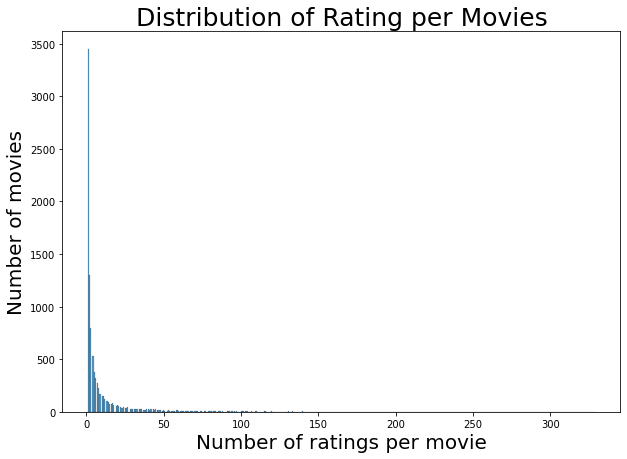

In [ ]:
#visualize the distribution of ratings each movie
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
sns.histplot(data=rating_per_movie_pdf, x='rating')
ax.set_xlabel('Number of ratings per movie', fontsize=20)
ax.set_ylabel('Number of movies', fontsize=20)
ax.set_title('Distribution of Rating per Movies', fontsize=25)

**Notes: Most of movie has less than 50 ratings and 3446 movies only has 1 rating.

**Average rating of movies**

In [ ]:
#average rating of movies
avg_rating_pdf = ratings_df.groupBy('movieid').agg(round(mean('rating'), 2)).select(col('movieid').alias('movieId'),col('round(avg(rating), 2)')\
  .alias('avg_rating')).toPandas()
avg_rating_pdf.head()

,movieId,avg_rating
0,296,3.99
1,1090,3.98
2,115713,3.58
3,3210,3.37
4,88140,3.67


Text(0.5, 1.0, 'Distribution of Average Ratings')

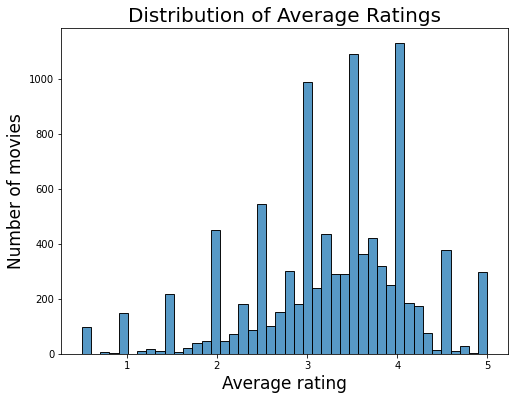

In [ ]:
#Visualize the distribution of average raing 
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.histplot(data = avg_rating_pdf, x='avg_rating')
ax.set_xlabel('Average rating', fontsize=17)
ax.set_ylabel('Number of movies', fontsize=17)
ax.set_title('Distribution of Average Ratings', fontsize=20)

**Distribution of movies in each year**

First, extract year from movie's title.

In [ ]:
#convert to pandas
year_movies_pdf = movies_df.toPandas()

#remove white space from right 
year_movies_pdf['title'] = year_movies_pdf['title'].str.rstrip()

#extract year of movie from title, and creates new conlumn for year
year_movies_pdf['year'] = year_movies_pdf['title'].str.slice(-5,-1)

#replace Non year with median number of year
#median_year = movies_pdf['year'].median()
year_movies_pdf['year']= year_movies_pdf['year'].apply(lambda x: x if x.isnumeric() else '1999')

#some movie has year but not formated corectly
#replace with correct year
year_movies_pdf.loc[5019,'year']='2002'
year_movies_pdf.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [ ]:
#count number of movies in each year
cnt_yr_movies = year_movies_pdf.groupby(by='year').count().rename(columns={'movieId':'num_movies'}).drop(columns=['title', 'genres']).reset_index()
cnt_yr_movies.head(5)

,year,num_movies
0,1902,1
1,1903,1
2,1908,1
3,1915,1
4,1916,4


Text(0.5, 1.0, 'Distribution of Movies Each Year')

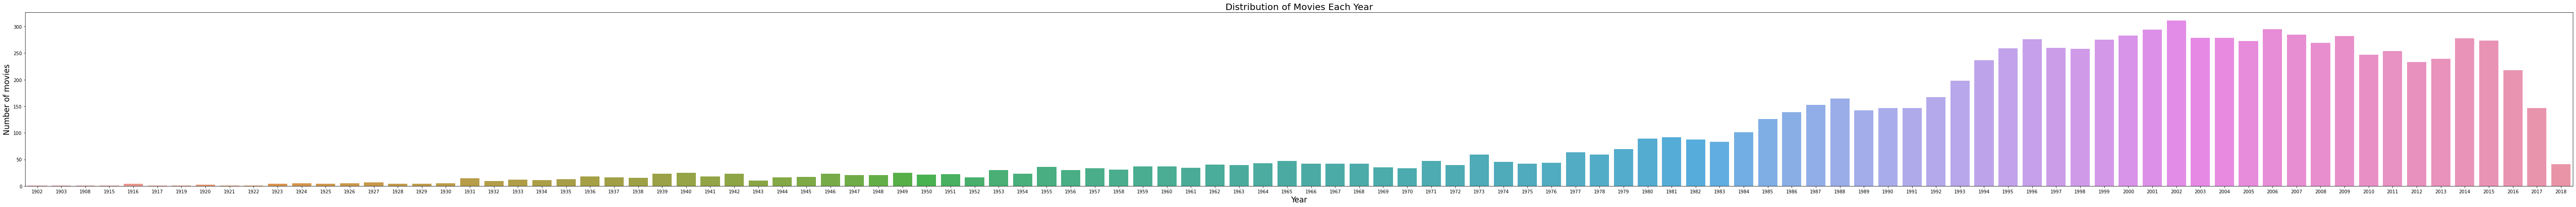

In [ ]:
#visualize the distribution of movie in year
fig = plt.figure(figsize=(100,7))
ax = fig.add_subplot(111)
sns.barplot(data = cnt_yr_movies, x='year', y='num_movies')
ax.set_xlabel('Year', fontsize=17)
ax.set_ylabel('Number of movies', fontsize=17)
ax.set_title('Distribution of Movies Each Year', fontsize=20)

In [ ]:
new_movies_kdf = ks.from_pandas(cnt_yr_movies)
#Bucketing continuous variable 'year' into discrete, to prevent overfitting in tree model.
from pyspark.ml.feature import Bucketizer

year_buckets = [-float('inf'), 1960, 1970,1980,1990,2000,2010, float('inf')]

bucketizer = Bucketizer(splits=year_buckets, inputCol='year', outputCol='yearBins')

#converts year from string to float.
new_movies_kdf['year'] = new_movies_kdf['year'].astype('float')

#transform original data into its bucket index.
new_movies_kdf['year'] = new_movies_kdf['year'].astype('float')

#converts from koalas to spark DataFrame
tmp = new_movies_kdf.to_spark()

bucketedYear_df = bucketizer.transform(tmp)

bucketedYear_pdf = bucketedYear_df.toPandas()
bucketedYear_pdf.head()

,year,num_movies,yearBins
0,1902.0,1,0.0
1,1903.0,1,0.0
2,1908.0,1,0.0
3,1915.0,1,0.0
4,1916.0,4,0.0


Text(0.5, 1.0, 'Distribution of Movies Each Year')

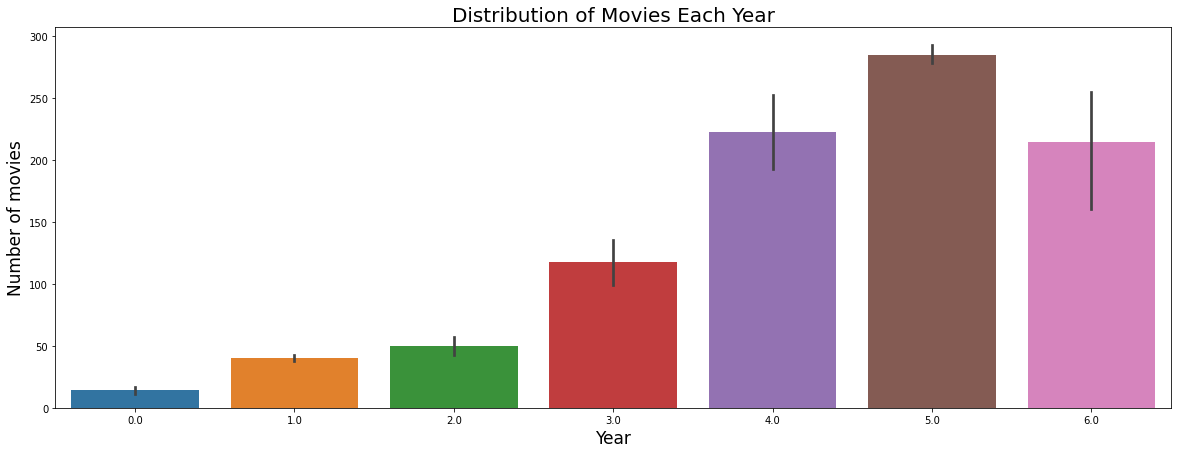

In [ ]:
#visualize movie diatribution after bucketized
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
sns.barplot(data = bucketedYear_pdf, x='yearBins', y='num_movies' )
ax.set_xlabel('Year', fontsize=17)
ax.set_ylabel('Number of movies', fontsize=17)
ax.set_title('Distribution of Movies Each Year', fontsize=20)

#locs, labels = xticks()
#xticks(np.arange(0, 1, step=0.2), [-float('inf'), 1960, 1970,1980,1990,2000,2010, float('inf')] )


#Part3: Model Training/Embedding

##Part 3_1: Spark ALS based approach for training model

In [ ]:
#import ALS model, elvauator, cross validation packages
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

**Note: the original data types are string type. we need to convert to interger or float types to feed the model.

In [ ]:
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
#drop redundant column
movie_ratings_df = ratings_df.drop('timestamp')

#converts data type for model training.
movie_ratings_df = movie_ratings_df.withColumn('userId', ratings_df['userId'].cast(IntegerType()))
movie_ratings_df = movie_ratings_df.withColumn('movieId', ratings_df['movieId'].cast(IntegerType()))
movie_ratings_df = movie_ratings_df.withColumn('rating', ratings_df['rating'].cast(FloatType()))

movie_ratings_df.cache()
movie_ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)



**Split the data into 80% traing and 20% test. Define RMSE as evaluation metircs.**

In [ ]:
#split data set into training and test  data set
(training, test) = movie_ratings_df.randomSplit([0.8,0.2], seed = 1)

#Creates ALS model
#coldStartStrategy:  “drop” : drop the unseen data in the validation.
als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')

#Define evaliator as RMSE
RMSE_evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

#Tune model using ParamGridBuilder
#regParam specifies the regularization parameter
paramGrid = ParamGridBuilder()\
            .addGrid(als.regParam, [0.1])\
            .addGrid(als.maxIter, [9])\
            .addGrid(als.rank, [5])\
            .build()

#Build Cross Validation
crossval = CrossValidator(estimator = als,
                          estimatorParamMaps = paramGrid,
                          evaluator = RMSE_evaluator,
                          numFolds = 5,
                          collectSubModels = True,
                          seed = 1)


Note: When using simple random splits as in Spark’s CrossValidator or TrainValidationSplit, it is actually very common to encounter users and/or items in the evaluation set that are not in the training set. By default, Spark assigns NaN predictions during ALSModel.transform when a user and/or item factor is not present in the model.We set cold start strategy to ‘drop’ to ensure we don’t get NaN evaluation metrics

In [ ]:
import time
start = time.time()

#Fit ALS model to trainging data
cv_model = crossval.fit(training)

#Extracts best model form the tuning exercise using ParamGridBuilder
best_model = cv_model.bestModel

end = time.time()
print('Training model costs %.3f second.' %(end-start))

Training model costs 85.869 second.


In [ ]:
start = time.time()
#Calculate the training RMSE
predictions = cv_model.transform(training)
rmse_train = RMSE_evaluator.evaluate(predictions)
#prit out parameters of the best model 
end = time.time()
print('Predict training costs %.3f second.' %(end-start))
print('**The Best Model**')
print('rank: ', best_model._java_obj.parent().getRank())
print('regParam: ',best_model._java_obj.parent().getRegParam())
print('MaxIter: ', best_model._java_obj.parent().getMaxIter())
print('Root-mean-suare-error for training data: ', rmse_train)

Predict training costs 10.239 second.
**The Best Model**
rank:  5
regParam:  0.1
MaxIter:  9
Root-mean-suare-error for training data:  0.6429172429020982


In [ ]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   191|    148|   5.0|  4.923914|
|   133|    471|   4.0| 3.2005422|
|   597|    471|   2.0| 3.6765919|
|   385|    471|   4.0| 3.7811663|
|   436|    471|   3.0|  3.649142|
|   602|    471|   4.0| 3.3615584|
|   409|    471|   3.0| 3.9699626|
|   372|    471|   3.0| 3.3311334|
|   599|    471|   2.5| 2.8966234|
|   603|    471|   4.0|  3.101512|
|   182|    471|   4.5|  4.015343|
|   218|    471|   4.0| 3.6638455|
|   474|    471|   3.0| 2.8979506|
|   500|    471|   1.0|  2.250864|
|    57|    471|   3.0| 3.7002244|
|   387|    471|   3.0| 2.9757717|
|   610|    471|   4.0|  3.801002|
|   217|    471|   2.0|  2.392417|
|   555|    471|   3.0| 2.6053698|
|   176|    471|   5.0|  4.233411|
+------+-------+------+----------+
only showing top 20 rows



**Train model use whole data.**

In [ ]:
import time
start = time.time()

estimator = ALS(rank=5, maxIter=9, regParam=0.1, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
model_with_whole = estimator.fit(movie_ratings_df)
predictions = model_with_whole.transform(test)
rmse_whole_data = RMSE_evaluator.evaluate(predictions)
print('**The Best Model with whole data set**')
print('Root-mean-suare-error for test data: ', rmse_whole_data)

end = time.time()
print('Training model costs %.3f second.' %(end-start))

**The Best Model with whole data set**
Root-mean-suare-error for test data:  0.6564829984296153
Training model costs 16.071 second.


**Note: The RMSE just about 1% higer with whole dataset than training data which is make sense and aceptable.




**User Embedding Vector**

In [ ]:
#save user embedding vectors
best_model.userFactors.toPandas().to_csv('/content/drive/MyDrive/Projects/MovieRecommendation/ALS_user_embedding.csv', index=False)

In [ ]:
als_user_embedding = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/ALS_user_embedding.csv', header=True)
als_user_embedding.show(truncate=False)

+---+---------------------------------------------------------------------------------------------------------+
|id |features                                                                                                 |
+---+---------------------------------------------------------------------------------------------------------+
|10 |[1.1817792654037476, -0.2940300703048706, 1.6403700113296509, -0.07358551770448685, 0.1320478767156601]  |
|20 |[1.1260699033737183, -0.20444677770137787, 0.8952229022979736, -0.17196527123451233, -1.4942396879196167]|
|30 |[0.6988054513931274, -0.23221157491207123, 1.255372405052185, -1.27004075050354, -0.7316378951072693]    |
|40 |[0.6841102838516235, -0.6232526302337646, 1.1214433908462524, -0.5738973021507263, -1.3922480344772339]  |
|50 |[0.3403725326061249, -0.2263503521680832, 0.3204931318759918, -0.5198656320571899, -1.2873259782791138]  |
|60 |[0.9194726347923279, -0.27002981305122375, 0.9660966992378235, -0.9169602394104004, -0.696727871894

**Movie Embedding Vector**

In [ ]:
#save user embedding vectors
best_model.itemFactors.toPandas().to_csv('/content/drive/MyDrive/Projects/MovieRecommendation/ALS_movie_embedding.csv', index=False)

In [ ]:
als_movie_embedding = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/ALS_movie_embedding.csv', header=True)
als_movie_embedding.show(truncate=False)

+---+---------------------------------------------------------------------------------------------------------+
|id |features                                                                                                 |
+---+---------------------------------------------------------------------------------------------------------+
|10 |[0.7543582320213318, -0.43684113025665283, 1.1783419847488403, -1.244630217552185, -0.6357488632202148]  |
|20 |[0.5292847156524658, 0.6717875599861145, 0.5208002924919128, -1.2557189464569092, -0.8527101874351501]   |
|30 |[0.29009050130844116, 0.5124908685684204, -0.1266455203294754, 0.3089078962802887, -2.4219279289245605]  |
|40 |[0.8130141496658325, -0.6409873962402344, 0.7687512636184692, -2.2855961322784424, -0.8852028250694275]  |
|50 |[0.9116767048835754, -0.13672789931297302, 0.8309813141822815, -1.4305728673934937, -1.5520011186599731] |
|60 |[1.038580060005188, -0.47373589873313904, 1.0702707767486572, -0.5647756457328796, -0.8667149543762

##Part3_2: Item2vec Embedding

Inorder to get the item embedding, we need to tranform datafram as (userid, itemids).

Pro: embedding of item is base on the sequence of user interactions.

Embedding the of movie := we predicts (embed) the movie base on sequence of user interations with movies where ratinge > 4.

**Step1:** 
filter movie that each user like. We set a threshold if movie recieved rating > 4, otherwise remove the rating(consider the user don't like) we want to use the movie embeeding to search that user may also like

**Step2:**
movie embedding = groupby userid -> each userid -> list of movieid that user has whatched.

**Step3:** using word2vec model. input = list of movieid, Output: embedding of movies

**User Embedding:** Average of movie vectors that user has watched.

####Movie Embedding

In [ ]:
from pyspark.sql import functions as F
#transform dataframe into (userid, itemids)

#filter the movie only has rating score > mean score
avg_rating = ratings_df.agg({'rating': 'mean'})
positive_df = ratings_df.filter(ratings_df['rating'] > avg_rating.head()[0])

#convert spark datafram to koalas dataframe for preprocessing
positive_kdf = positive_df.to_koalas()

#group by userId and merge all movieId into one list
#首先groupby 'userId', 選擇每個group的movieId, lambda 的 x 是指一整個group, apply=>在每個group x 要join x裡面的每個elem,前提是要把每個elem m 轉換成string 
kdf_group = positive_kdf.groupby(['userId'])['movieId'].apply(lambda x: ' '.join([str(m) for m in x])).reset_index()
kdf_group.head()

spark-3.0.2-bin-hadoop2.7/python/pyspark/sql/pandas/group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  "more details.", UserWarning)


,userId,movieId
0,1,1 3 6 47 50 101 110 151 157 163 216 231 235 26...
1,10,588 912 1907 3578 4306 4447 4993 4995 5952 653...
2,100,11 16 17 28 62 74 89 95 168 222 234 237 261 26...
3,101,223 233 1093 1127 1210 1719 2318 2395 2396 256...
4,102,3 47 223 288 296 318 344 349 356 364 454 457 4...


In [ ]:
#Save the data 
kdf_group.toPandas().to_csv('/content/drive/MyDrive/Projects/MovieRecommendation/movielens_uid_movieids.csv', index=False)

In [ ]:
#Loand (userid, movieids) dataframe
userid_movieids_df = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/movielens_uid_movieids/uid_movieids.csv',header=True)
userid_movieids_df.show(5)

In [ ]:
#word2vec input must be list of string type
#convert series of movieId to list and split each elenm by space
userid_movieids_df = userid_movieids_df.withColumn('movie_ids', F.split(userid_movieids_df.movieId, ' '))
userid_movieids_df.show(5)

In [ ]:
from pyspark.ml.feature import Word2Vec
#build and train item2vec (word2vec)model
Word2Vec = Word2Vec(
              vectorSize=5,
              minCount=0,
              inputCol='movie_ids',
              outputCol='movie_2vec')

model = Word2Vec.fit(userid_movieids_df)

In [ ]:
#output each item(movieid) embedding
#word := movieid
movieid_2vec = model.getVectors()

#rename column 'word' to 'movie_id'
movieid_2vec=movieid_2vec.withColumnRenamed('word', 'movieId')
movieid_2vec.show(3, truncate=False)

In [ ]:
#Save the movie embedding
movieid_2vec.toPandas().to_csv('/content/drive/MyDrive/Projects/MovieRecommendation/movies_embedding.csv', index=False)

In [ ]:
#load movie embedding from drive
movieid_2vec = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/movies_embedding.csv', header=True)
movieid_2vec.show(3) 

+-------+--------------------+
|movieId|              vector|
+-------+--------------------+
|  26985|[-0.0056934589520...|
|   5451|[-0.0513044968247...|
|   4018|[-0.0867667347192...|
+-------+--------------------+
only showing top 3 rows



####User Embedding

In [ ]:
ratings_kdf.head()

In [ ]:
#convert movieid_2vec to koalas format
movieid_2vec = movieid_2vec.to_koalas()

#joing rating dataframe with movie's embedding
userid_2vec_kdf = ratings_kdf.set_index('movieId').join(movieid_2vec.set_index('movieId')).reset_index()

#drop rating and timestamp
userid_2vec_kdf = userid_2vec_kdf.drop(['rating', 'timestamp'], axis=1)
userid_2vec_kdf.head(5)

**Note: always use koalas formate to avoid formate error!!!!!**. spark dataframe formate error

In [ ]:
#convert vector form object type to array and drop nan vector
userid_2vec_kdf = userid_2vec_kdf.apply(lambda x: list(x)).dropna()

In [ ]:
#using pandas dataframe to do numpy array operation
userid_2vec_pdf = userid_2vec_kdf.toPandas()

#preprocessing the string of movie embedding to numpy
#remove '[' and ']' and split with ',' and putin list formate
userid_2vec_pdf['vector'] = userid_2vec_pdf.vector.apply(lambda x: [float(m) for m in x[1:-2].split(',')])

#convert list to numy array for array operation
userid_2vec_pdf['vector'] = userid_2vec_pdf.vector.apply(lambda x: np.array(x))

#drop movieId column
userid_2vec_pdf.drop(['movieId'], axis=1, inplace=True)

#group by userID and stack all movie embedding and then get mean of it.
user_embedding = userid_2vec_pdf.groupby(['userId']).agg(mean=('vector', lambda x: np.vstack(x).mean(axis=0).tolist())).reset_index()

#rename mean to user2vec
user_embedding = user_embedding.rename(columns={'mean':'user2vec'})
user_embedding.head(5)

In [ ]:
#Save user embedding
user_embedding.to_csv('/content/drive/MyDrive/Projects/MovieRecommendation/user_embedding.csv', index=False)

Note: the optimal model would be regParam=0.3, rank=10, MaxIter=13 with 0.8714 rmse. 

##Part3_3: User Embedding With Tag and Most Popular Item in Each Genre

**Step1:** Build a user tag embedding. ( {userid1: {genre1:score, genre2:score}} ->nomalize each gen score)


**Step2:** Build a dictionary store most popular item in each genre. ( {genre1:{movieid1:score, movieid2:score}} )

###Part3_3_1:User's Tag Embedding

In [ ]:
#merge rating and movie dataframe
merge_kdf = ratings_kdf.merge(movies_kdf, left_on='movieId', right_on='movieId').drop('timestamp', axis=1)

#drop all Nan rows
clean_merge_kdf = merge_kdf.dropna()
clean_merge_kdf.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
from collections import defaultdict
#create dictionary to calculate tag score for each user
user_genres = defaultdict(int)

#linear scan each row of rating and accumulate the genres score for each user
for index, row in clean_merge_kdf.iterrows():
  user_id = row['userId']
  for genre in row['genres'].split('|'):
    if user_id not in user_genres.keys():
      user_genres[user_id]=defaultdict(int)
    user_genres[user_id][genre] += row['rating']

In [ ]:
#Normalize each user tag's score

#Convert dictionary to dataframe
user_genres_pd = pd.DataFrame.from_dict(user_genres).transpose()

#Drop no genres listed and fill Nan with 0
clean_user_genres_pd = user_genres_pd.drop(columns=['(no genres listed)'])
clean_user_genres_pd = clean_user_genres_pd.fillna(0)

#Apply min-max normalization for each user's tag score
norm_user_genres_pd=clean_user_genres_pd.apply(lambda x: round((x - np.min(x)) / (np.max(x) - np.min(x)), 3), axis=1)
norm_user_genres_pd = norm_user_genres_pd.reset_index().rename(columns={'index':'userId'})
norm_user_genres_pd

,userId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Action,Crime,Thriller,Mystery,Horror,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary
0,1,0.959,0.350,0.491,0.913,0.519,0.288,1.000,0.504,0.586,0.193,0.152,0.792,0.254,0.077,0.434,0.265,0.013,0.000,0.000
1,2,0.189,0.000,0.000,0.424,0.000,0.068,0.659,0.576,0.561,0.121,0.045,1.000,0.068,0.053,0.235,0.000,0.000,0.227,0.197
2,3,0.476,0.032,0.040,0.143,0.214,0.040,0.794,0.016,0.460,0.079,0.595,0.190,0.040,0.000,1.000,0.008,0.000,0.000,0.000
3,4,0.248,0.051,0.084,0.872,0.161,0.465,0.193,0.241,0.318,0.186,0.034,1.000,0.053,0.084,0.075,0.147,0.031,0.000,0.012
4,5,0.274,0.274,0.389,0.547,0.305,0.358,0.295,0.484,0.337,0.042,0.032,1.000,0.105,0.063,0.053,0.232,0.000,0.116,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,0.189,0.052,0.057,0.565,0.126,0.499,0.176,0.178,0.260,0.124,0.059,1.000,0.087,0.015,0.100,0.055,0.004,0.011,0.000
606,607,0.474,0.061,0.198,0.556,0.228,0.310,0.815,0.313,0.763,0.240,0.438,1.000,0.076,0.024,0.356,0.055,0.000,0.015,0.000
607,608,0.594,0.164,0.211,1.000,0.332,0.304,0.949,0.536,0.942,0.240,0.321,0.991,0.055,0.015,0.560,0.079,0.000,0.035,0.003
608,609,0.500,0.047,0.094,0.359,0.047,0.250,0.531,0.328,0.719,0.000,0.109,1.000,0.219,0.062,0.234,0.000,0.000,0.047,0.094


In [ ]:
#save user embedding dataframe
norm_user_genres_pd.to_csv('/content/drive/MyDrive/Projects/MovieRecommendation/Tag_norm_user_gernes.csv', index=False)

In [ ]:
#merge all columns into one list
norm_user_genres_pd['u2tag'] = norm_user_genres_pd[norm_user_genres_pd.columns[1:]].apply(lambda x: ','.join(x.astype(str)), axis=1)

#Select only userId and u2tag columns
u2tag = norm_user_genres_pd[['userId','u2tag']]
u2tag

,userId,u2tag
0,1,"0.959,0.35,0.491,0.913,0.519,0.288,1.0,0.504,0..."
1,2,"0.189,0.0,0.0,0.424,0.0,0.068,0.659,0.576,0.56..."
2,3,"0.476,0.032,0.04,0.143,0.214,0.04,0.794,0.016,..."
3,4,"0.248,0.051,0.084,0.872,0.161,0.465,0.193,0.24..."
4,5,"0.274,0.274,0.389,0.547,0.305,0.358,0.295,0.48..."
...,...,...
605,606,"0.189,0.052,0.057,0.565,0.126,0.499,0.176,0.17..."
606,607,"0.474,0.061,0.198,0.556,0.228,0.31,0.815,0.313..."
607,608,"0.594,0.164,0.211,1.0,0.332,0.304,0.949,0.536,..."
608,609,"0.5,0.047,0.094,0.359,0.047,0.25,0.531,0.328,0..."


In [ ]:
#Save u2tag embedding
u2tag.to_csv('/content/drive/MyDrive/Projects/MovieRecommendation/Tag_u2tag.csv', index=False)

In [ ]:
#Load u2tag data
u2tag_df = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/Tag_u2tag.csv', header=True)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

#Convert u2tag into array by F.split()
u2tag_df = u2tag_df.withColumn('u2tag_vector', F.split(u2tag_df.u2tag, ','))

#Drop the original u2tag column
u2tag_df = u2tag_df.drop('u2tag')
u2tag_df.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------+
|userId|u2tag_vector                                                                                                                     |
+------+---------------------------------------------------------------------------------------------------------------------------------+
|1     |[0.959, 0.35, 0.491, 0.913, 0.519, 0.288, 1.0, 0.504, 0.586, 0.193, 0.152, 0.792, 0.254, 0.077, 0.434, 0.265, 0.013, 0.0, 0.0]   |
|2     |[0.189, 0.0, 0.0, 0.424, 0.0, 0.068, 0.659, 0.576, 0.561, 0.121, 0.045, 1.0, 0.068, 0.053, 0.235, 0.0, 0.0, 0.227, 0.197]        |
|3     |[0.476, 0.032, 0.04, 0.143, 0.214, 0.04, 0.794, 0.016, 0.46, 0.079, 0.595, 0.19, 0.04, 0.0, 1.0, 0.008, 0.0, 0.0, 0.0]           |
|4     |[0.248, 0.051, 0.084, 0.872, 0.161, 0.465, 0.193, 0.241, 0.318, 0.186, 0.034, 1.0, 0.053, 0.084, 0.075, 0.147, 0.031, 0.0, 0.012]|
|5     |[0.274, 0.274, 0.38

###Part3_3_2: Movie To Tag: Calculate Popuparity Of Movies In Each Genre 

Build a dictionary like {genre: [movie, score]} where the score of movie in each genre is accumulated by ratings from users.

In [ ]:
from collections import defaultdict
# Build a dictionary like {genre: [movie, score]}

#Create an empty dictionary
genre_hots = defaultdict(dict)

#linear scan each rating and accumulate the rating to each genre
for index, row in merge_kdf.iterrows():
    movie_id = row["movieId"]
    for genre in row["genres"].split("|"):
      if movie_id not in genre_hots[genre]:
        genre_hots[genre][movie_id] = 0.0
      genre_hots[genre][movie_id] += row["rating"]

In [ ]:
#Nomalization
for genre in genre_hots:
  min_val = min(list(genre_hots[genre].values()))
  max_val = max(list(genre_hots[genre].values()))
  for movie_id, score in genre_hots[genre].items():
    genre_hots[genre][movie_id] = round((score-min_val) / (max_val-min_val), 3)

In [ ]:
#Show the movie score in the tag of Adventure 
sorted(genre_hots["Mystery"].items(), key=lambda x: x[1], reverse=True)[:10]

[(50, 1.0),
 (47, 0.933),
 (32, 0.815),
 (2762, 0.806),
 (4226, 0.758),
 (79132, 0.672),
 (648, 0.663),
 (1089, 0.637),
 (5445, 0.505),
 (4878, 0.502)]

In [ ]:
#Convert dictionary to movies
genre_hots_df = pd.DataFrame.from_dict(genre_hots).fillna(0).reset_index().rename(columns={'index':'movieId'})
genre_hots_df.head()

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Action,Crime,Thriller,Mystery,Horror,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,(no genres listed)
0,1,0.794,1.0,1.0,0.615,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
1,101,0.081,0.0,0.0,0.063,0.0,0.063,0.000,0.062,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2,231,0.383,0.0,0.0,0.297,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
3,260,1.000,0.0,0.0,0.000,0.0,0.000,0.911,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.911,0.0,0.0,0.0,0.0,0.0
4,316,0.445,0.0,0.0,0.000,0.0,0.000,0.405,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.405,0.0,0.0,0.0,0.0,0.0


In [ ]:
#save norm movie to tag embedding
genre_hots_df.to_csv('/content/drive/MyDrive/Projects/MovieRecommendation/Tag_norm_movie_gernes.csv', index=False)

In [ ]:
#merge all genre columns into on array
genre_hots_df['i2tag'] = genre_hots_df[genre_hots_df.columns[1:]].apply(lambda x: ','.join(x.astype(str)), axis=1)
genre_hots_df.head()

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Action,Crime,Thriller,Mystery,Horror,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,(no genres listed),i2tag
0,1,0.794,1.0,1.0,0.615,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,"0.794,1.0,1.0,0.615,1.0,0.0,0.0,0.0,0.0,0.0,0...."
1,101,0.081,0.0,0.0,0.063,0.0,0.063,0.000,0.062,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,"0.081,0.0,0.0,0.063,0.0,0.063,0.0,0.062,0.0,0...."
2,231,0.383,0.0,0.0,0.297,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,"0.383,0.0,0.0,0.297,0.0,0.0,0.0,0.0,0.0,0.0,0...."
3,260,1.000,0.0,0.0,0.000,0.0,0.000,0.911,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.911,0.0,0.0,0.0,0.0,0.0,"1.0,0.0,0.0,0.0,0.0,0.0,0.911,0.0,0.0,0.0,0.0,..."
4,316,0.445,0.0,0.0,0.000,0.0,0.000,0.405,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.405,0.0,0.0,0.0,0.0,0.0,"0.445,0.0,0.0,0.0,0.0,0.0,0.405,0.0,0.0,0.0,0...."


In [ ]:
#select only movieId and i2tag columns
movie2tag_df = genre_hots_df[['movieId','i2tag']]

#Save dataframe
movie2tag_df.to_csv('/content/drive/MyDrive/Projects/MovieRecommendation/Tag_movie2tag.csv', index=False)

**Note:** The dataframe shows the popularity of each movie in each genre

In [ ]:
#Read movie popularity embedding 
genre_hots_df = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/Tag_movie2tag.csv', header=True)

#Part4: Applications
1. User Cold start issue: Give top 10 highest avg rated movies with at lease 50 reviews for new user.
2. Recommend movies for existed user. (use function .recommendForUserSubset(user_list, # of recommendations)
3. Update model(need to re-train model) for new user ratings. And give a recommendation after update.

##Part4_1: Recommend movies with ALS model

####Part4_1_1:Recommend movies for userid: 232 and 575

In [ ]:
from pyspark.sql.functions import *
#build user dataframe
user_list = spark.createDataFrame(pd.DataFrame({'userId':['232', '575']}))

#return top 5 movies recommended for each user id in the input data set. {user 232: [[movieid1, rating] [movieid2, rating]...]}
user_recommend = model_with_whole.recommendForUserSubset(user_list ,5)

#explode the recommend dataframe. Explode=>本來recomendation list 橫的變豎的， recommendation".*" 會把[movieid, rating]分成兩個columns
user_recommend_df = user_recommend.select('userId', explode('recommendations')\
                                  .alias('recommendation'))\
                                  .select('userId', 'recommendation.*')

#map the recommended movieId with title
recommendation_result = user_recommend_df.join(movies_df, on='movieId', how='left')
recommendation_result.show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|   5075|   232|4.9253697|  Waydowntown (2000)|              Comedy|
|   3379|   232|4.8496833| On the Beach (1959)|               Drama|
|  33649|   232|4.7099886|  Saving Face (2004)|Comedy|Drama|Romance|
| 102217|   232|4.7005925|Bill Hicks: Revel...|              Comedy|
|  92494|   232|4.7005925|Dylan Moran: Mons...|  Comedy|Documentary|
|  92494|   575| 5.495878|Dylan Moran: Mons...|  Comedy|Documentary|
| 102217|   575| 5.495878|Bill Hicks: Revel...|              Comedy|
|   1696|   575|5.3302197|         Bent (1997)|           Drama|War|
|  33779|   575|5.3098497|Eddie Izzard: Dre...|              Comedy|
|  89118|   575| 5.292138|Skin I Live In, T...|               Drama|
+-------+------+---------+--------------------+--------------------+



**List 5 recommend movies for user 232**

In [ ]:
res = recommendation_result.where('userId = 232')
res.show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|  33649|   232|4.9043913|  Saving Face (2004)|Comedy|Drama|Romance|
|   3379|   232| 4.786348| On the Beach (1959)|               Drama|
|  26073|   232| 4.727024|Human Condition I...|           Drama|War|
| 117531|   232| 4.727024|    Watermark (2014)|         Documentary|
|   7071|   232| 4.727024|Woman Under the I...|               Drama|
+-------+------+---------+--------------------+--------------------+



In [ ]:
#compare with the top movies what user rated.
res = ratings_df.join(movies_df, on='movieId', how='left').where('userId=232').orderBy(col('rating').desc())
res.show(truncate=False)

+-------+------+------+----------+-------------------------------------------------+------------------------------------------------+
|movieId|userId|rating|timestamp |title                                            |genres                                          |
+-------+------+------+----------+-------------------------------------------------+------------------------------------------------+
|2762   |232   |5.0   |1218165016|Sixth Sense, The (1999)                          |Drama|Horror|Mystery                            |
|1210   |232   |5.0   |1077235144|Star Wars: Episode VI - Return of the Jedi (1983)|Action|Adventure|Sci-Fi                         |
|2028   |232   |5.0   |1241823312|Saving Private Ryan (1998)                       |Action|Drama|War                                |
|7458   |232   |5.0   |1105237396|Troy (2004)                                      |Action|Adventure|Drama|War                      |
|296    |232   |5.0   |1241823280|Pulp Fiction (1994)         

**Note: The prediction is quite close to what user 232 like. the model recommend movies with Drama, Comedy, and Rmance genres,and the movies that user has rated with Drama, Romance and Comedy too.  

####Part4_1_2: Add new user into dataset and update model

In [ ]:
#initial userId
new_user_id = 0

#creates new user revies dataframe
# The format of each line is (my_user_id, movie ID, your rating)
new_user_ratings = [
     (new_user_id, 260,  5),
     (new_user_id, 1196, 5),
     (new_user_id, 480,  5),
     (new_user_id, 1210, 5),
     (new_user_id, 589,  5),
     (new_user_id, 2028, 1),
     (new_user_id, 1580, 5),
     (new_user_id, 110,  1),
     (new_user_id, 2571, 5),
     (new_user_id, 1270, 5)
]

new_user_ratings_df = spark.createDataFrame(new_user_ratings, ['userId','movieId','rating'])
print('New user movie ratings:')
new_user_ratings_df.show()

New user movie ratings:
+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     0|    260|     5|
|     0|   1196|     5|
|     0|    480|     5|
|     0|   1210|     5|
|     0|    589|     5|
|     0|   2028|     1|
|     0|   1580|     5|
|     0|    110|     1|
|     0|   2571|     5|
|     0|   1270|     5|
+------+-------+------+



In [ ]:
#Add new reviews to training data
updated_ratings_df = training.unionAll(new_user_ratings_df)

print ('The training dataset now has %s more entries than the original training dataset' %
       (updated_ratings_df.count() - training.count()))

The training dataset now has 10 more entries than the original training dataset


In [ ]:
#retrain the training model and gave prediction
import time
start = time.time()

estimator = ALS(rank=5, maxIter=9, regParam=0.1, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
model_with_whole = estimator.fit(updated_ratings_df)
predictions = model_with_whole.transform(test)
rmse_whole_data = RMSE_evaluator.evaluate(predictions)
print('**The Best Model with whole data set**')
print('Root-mean-suare-error for test data: ', rmse_whole_data)

end = time.time()
print('Training model costs %.3f second.' %(end-start))

**The Best Model with whole data set**
Root-mean-suare-error for test data:  0.8740665130806501
Training model costs 11.430 second.


**Note: the RMSE is much higher which make sense since our data set is not very large and some movies may only have few ratings. 

**Recommendations for new user with updated model.**

In [ ]:
#build user dataframe
user_list = spark.createDataFrame(pd.DataFrame({'userId':['0']}))

#return top 5 movies recommended for each user id in the input data set.
user_recommend = model_with_whole.recommendForUserSubset(user_list ,5)

#explode the recommend dataframe
user_recommend_df = user_recommend.select('userId', explode('recommendations')\
                                  .alias('recommendation'))\
                                  .select('userId', 'recommendation.*')

#map the recommended movieId with title
recommendation_result = user_recommend_df.join(movies_df, on='movieId', how='left')
recommendation_result.show()

+-------+------+---------+--------------------+------------------+
|movieId|userId|   rating|               title|            genres|
+-------+------+---------+--------------------+------------------+
|     82|     0|  8.40531|Antonia's Line (A...|      Comedy|Drama|
|  86290|     0|7.6047983|American: The Bil...|Comedy|Documentary|
|   1658|     0|7.3245893|Life Less Ordinar...|  Romance|Thriller|
|   3436|     0|7.1730304|  Dying Young (1991)|     Drama|Romance|
|   3061|     0| 7.087485|  Holiday Inn (1942)|    Comedy|Musical|
+-------+------+---------+--------------------+------------------+



In [ ]:
#compare with the top movies what user rated.
res = updated_ratings_df.join(movies_df, on='movieId', how='left').where('userId=0').orderBy(col('rating').desc())
res.show(truncate=False)

+-------+------+------+-----------------------------------------------------+--------------------------------+
|movieId|userId|rating|title                                                |genres                          |
+-------+------+------+-----------------------------------------------------+--------------------------------+
|1196   |0     |5.0   |Star Wars: Episode V - The Empire Strikes Back (1980)|Action|Adventure|Sci-Fi         |
|1210   |0     |5.0   |Star Wars: Episode VI - Return of the Jedi (1983)    |Action|Adventure|Sci-Fi         |
|589    |0     |5.0   |Terminator 2: Judgment Day (1991)                    |Action|Sci-Fi                   |
|480    |0     |5.0   |Jurassic Park (1993)                                 |Action|Adventure|Sci-Fi|Thriller|
|260    |0     |5.0   |Star Wars: Episode IV - A New Hope (1977)            |Action|Adventure|Sci-Fi         |
|1270   |0     |5.0   |Back to the Future (1985)                            |Adventure|Comedy|Sci-Fi         |
|

In [ ]:
len(ratings_kdf[ratings_kdf['movieId']=='1196'])

211

In [ ]:
len(ratings_kdf[ratings_kdf['movieId']=='1210'])

196

In [ ]:
len(ratings_kdf[ratings_kdf['movieId']=='589'])

224

In [ ]:
len(ratings_kdf[ratings_kdf['movieId']=='480'])

238

In [ ]:
len(ratings_kdf[ratings_kdf['movieId']=='260'])

251

In [ ]:
len(ratings_kdf[ratings_kdf['movieId']=='1270'])

171

In [ ]:
len(ratings_kdf[ratings_kdf['movieId']=='1580'])

165

In [ ]:
len(ratings_kdf[ratings_kdf['movieId']=='2028'])

188

In [ ]:
len(ratings_kdf[ratings_kdf['movieId']=='232'])

14

**Notes: the recommendation is very close what user like. User rated movie with Action, Comedy in 5 rating score. 

##Part4_2: Recommendation with item2vect

####Part4_2_1: Recommend movies for userid:232

In [ ]:
from scipy.spatial import distance
import numpy as np
import json


def rec_u2i(movie_embeddings_pdf, user_embeddings_pdf, ratings_pdf, user_id, num_of_rec):
  '''input: movie_embedding_pdf = movie embedding dataframe in Pandas formate
            user_embedding := user's embedding vector
            num_od_rec: number of movie recommendations''' 
  #get target user embedding
  target_user_embedding_str = user_embeddings_pdf.loc[user_embeddings_pdf['userId']==user_id].iloc[0]['user2vec']

  #convert user and movie embedding formate from string to numpy array 
  target_user_embedding =  np.array(json.loads(target_user_embedding_str))
  movie_embeddings_pdf['vector'] = movie_embeddings_pdf['vector'].map(lambda x: np.array(json.loads(x)))

  #calculate similarity between user and movie with coisin diatance
  movie_embeddings_pdf['similarity'] = movie_embeddings_pdf['vector'].map(lambda x: 1 - distance.cosine(target_user_embedding, x))
  res = movie_embeddings_pdf.merge(movies_pdf, on='movieId', how='left').sort_values(by='similarity', ascending=False)
  return res[:num_of_rec]

In [ ]:
#load user embedding file
user_embeddings = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/user_embedding.csv', header=True)
user_embeddings.cache()

movie_embeddings = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/movies_embedding.csv', header=True)
movie_embeddings.cache()

#convert to pandas dataframe
user_embeddings_pdf=user_embeddings.toPandas()
movie_embeddings_pdf=movie_embeddings.toPandas()
movies_pdf = movies_df.toPandas()

In [ ]:
#recommend 10 movies for user 232
rec_u2i(movie_embeddings_pdf, user_embeddings_pdf, movies_pdf, '232', 10)

,movieId,vector,similarity,title,genres
2150,166534,"[0.04013635218143463, -0.23429596424102783, -0...",0.997375,Split (2017),Drama|Horror|Thriller
3313,65216,"[0.006009471602737904, -0.13057750463485718, -...",0.995810,Defiance (2008),Drama|Thriller|War
3195,3062,"[0.032002102583646774, -0.14794921875, -0.1329...",0.994162,"Longest Day, The (1962)",Action|Drama|War
3694,2144,"[0.0005465345457196236, -0.17883643507957458, ...",0.993673,Sixteen Candles (1984),Comedy|Romance
4004,97306,"[0.04584101587533951, -0.22129590809345245, -0...",0.992546,Seven Psychopaths (2012),Comedy|Crime
4606,5791,"[0.060974229127168655, -0.3579452931880951, -0...",0.991934,Frida (2002),Drama|Romance
5674,144478,"[0.04206379875540733, -0.24501216411590576, -0...",0.991283,"Sex, Drugs & Taxation (2013)",Comedy|Drama
46,2728,"[0.0250712800770998, -0.15138621628284454, -0....",0.989984,Spartacus (1960),Action|Drama|Romance|War
3085,5959,"[0.03504616394639015, -0.13100659847259521, -0...",0.989620,Narc (2002),Crime|Drama|Thriller
6162,2872,"[0.01501871831715107, -0.11487151682376862, -0...",0.988273,Excalibur (1981),Adventure|Fantasy


In [ ]:
#Compare with the movies that userid=232 has rated
rating_232 = ratings_df[ratings_df['userId']==232]
rating_232 = rating_232.join(movies_df, on='movieId').sort(col('rating').desc())
rating_232.show(truncate=False)

+-------+------+------+----------+-------------------------------------------------+------------------------------------------------+
|movieId|userId|rating|timestamp |title                                            |genres                                          |
+-------+------+------+----------+-------------------------------------------------+------------------------------------------------+
|2762   |232   |5.0   |1218165016|Sixth Sense, The (1999)                          |Drama|Horror|Mystery                            |
|1210   |232   |5.0   |1077235144|Star Wars: Episode VI - Return of the Jedi (1983)|Action|Adventure|Sci-Fi                         |
|2028   |232   |5.0   |1241823312|Saving Private Ryan (1998)                       |Action|Drama|War                                |
|7458   |232   |5.0   |1105237396|Troy (2004)                                      |Action|Adventure|Drama|War                      |
|296    |232   |5.0   |1241823280|Pulp Fiction (1994)         

**Note:** The recommendations are very close to the movies what user 232 has rated!! eventhoug the training data is only 100k.

####Part4_2_2: Find Similar movies for movieid:471

In [ ]:
#get the embedding vector for movieId:232
movieid_2vec_kdf = movieid_2vec.to_koalas()
movie_embedding_232 = movieid_2vec_kdf[movieid_2vec_kdf['movieId']=='232']
movie_embedding_232.head()

,movieId,vector
5562,232,"[0.062241263687610626,0.11272577941417694,0.14..."


In [ ]:
#convert vector in string to np array
#first convert to pandas formate
movieid_2vec_pdf = movieid_2vec.toPandas()

#preprocessing the string of movie embedding to numpy
#remove '[' and ']' and split with ',' and putin list formate
movieid_2vec_pdf['vector'] = movieid_2vec_pdf.vector.apply(lambda x: [float(m) for m in x[1:-2].split(',')])

#convert list to numy array for array operation
movieid_2vec_pdf['vector'] = movieid_2vec_pdf.vector.apply(lambda x: np.array(x))

movieid_2vec_pdf.head()

,movieId,vector
0,26985,"[-0.005693458952009678, 0.011207448318600655, ..."
1,5451,"[-0.051304496824741364, -0.08262942731380463, ..."
2,4018,"[-0.08676673471927643, -0.12443593144416809, -..."
3,4056,"[-0.06413149833679199, -0.07012783735990524, -..."
4,32584,"[0.0955715999007225, -0.07193352282047272, 0.0..."


In [ ]:
movieid_2vec_pdf = movieid_2vec.toPandas()

In [ ]:
movie_embedding_232 = movieid_2vec_pdf.loc[movieid_2vec_pdf['movieId']=='232', 'vector'].iloc[0]
movie_embedding_232

array([0.06224126, 0.11272578, 0.14804062, 0.11710586, 0.07701728])

In [ ]:
#find similar movies by calculating the cosine similarity 
from scipy.spatial import distance
import json
import numpy as np
movieid_2vec_pdf['vector'] = movieid_2vec_pdf['vector'].map(lambda x: np.array(json.loads(x)))
movieid_2vec_pdf['sim_val'] = movieid_2vec_pdf['vector'].map(lambda x: 1-distance.cosine(movie_embedding_232, x))

In [ ]:
movieid_2vec_pdf.head(5)

,movieId,vector,sim_val
0,26985,"[-0.005693458952009678, 0.011207448318600655, ...",0.025026
1,5451,"[-0.051304496824741364, -0.08262942731380463, ...",-0.556879
2,4018,"[-0.08676673471927643, -0.12443593144416809, -...",-0.916965
3,4056,"[-0.06413149833679199, -0.07012783735990524, -...",-0.565710
4,32584,"[0.0955715999007225, -0.07193352282047272, 0.0...",-0.448862


In [ ]:
movies_pdf = movies_df.toPandas()

In [ ]:
#join movieId with movie metadata
movie_merge = pd.merge(left=movieid_2vec_pdf,
                      right=movies_pdf, 
                      left_on='movieId',
                      right_on='movieId')
movie_merge.sort_values(by='sim_val', ascending=False).head()

,movieId,vector,sim_val,title,genres
5562,232,"[0.062241263687610626, 0.11272577941417694, 0....",1.000000,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance
5084,18,"[0.08197536319494247, 0.11581863462924957, 0.1...",0.993196,Four Rooms (1995),Comedy
5188,154,"[0.08247482776641846, 0.10832800716161728, 0.1...",0.981957,Beauty of the Day (Belle de jour) (1967),Drama
1249,44,"[0.0698385015130043, 0.21564367413520813, 0.18...",0.980877,Mortal Kombat (1995),Action|Adventure|Fantasy
5987,229,"[0.06318800151348114, 0.08486676216125488, 0.1...",0.977822,Death and the Maiden (1994),Drama|Thriller


In [ ]:
res = movie_merge.loc[movie_merge['movieId']=='232']
res

,movieId,vector,sim_val,title,genres
5562,232,"[0.062241263687610626, 0.11272577941417694, 0....",1.0,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance


##Part4_3: Recommend Movie to User:232 With Tag Embedding

**Step1:** Calulate each movie score to user.

**Step2:** Rank all the movie score and select top 20.

In [ ]:
#load u2taf embedding
u2tag_df = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/Tag_u2tag.csv', header=True)

#load movie2tag embedding
norm_movie2genres_df = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/Tag_norm_movie_gernes.csv', header=True )

In [ ]:
#remove (no geres listed) column to match the matix size of user genre for computaion.
norm_movie2genres_df = norm_movie2genres_df.drop('(no genres listed)')
norm_movie2genres_df.show()

+-------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|movieId|Adventure|Animation|Children|Comedy|Fantasy|Romance|Action|Crime|Thriller|Mystery|Horror|Drama|War|Western|Sci-Fi|Musical|Film-Noir|IMAX|Documentary|
+-------+---------+---------+--------+------+-------+-------+------+-----+--------+-------+------+-----+---+-------+------+-------+---------+----+-----------+
|      1|    0.794|      1.0|     1.0| 0.615|    1.0|    0.0|   0.0|  0.0|     0.0|    0.0|   0.0|  0.0|0.0|    0.0|   0.0|    0.0|      0.0| 0.0|        0.0|
|    101|    0.081|      0.0|     0.0| 0.063|    0.0|  0.063|   0.0|0.062|     0.0|    0.0|   0.0|  0.0|0.0|    0.0|   0.0|    0.0|      0.0| 0.0|        0.0|
|    231|    0.383|      0.0|     0.0| 0.297|    0.0|    0.0|   0.0|  0.0|     0.0|    0.0|   0.0|  0.0|0.0|    0.0|   0.0|    0.0|      0.0| 0.0|        0.0|
|    260|      1.0|      0.0|     0.0|   0.0| 

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

#Convert u2tag into array by F.split()
u2tag_df = u2tag_df.withColumn('u2tag_vector', F.split(u2tag_df.u2tag, ','))

#Drop the original u2tag column
u2tag_df = u2tag_df.drop('u2tag')
u2tag_df.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------+
|userId|u2tag_vector                                                                                                                     |
+------+---------------------------------------------------------------------------------------------------------------------------------+
|1     |[0.959, 0.35, 0.491, 0.913, 0.519, 0.288, 1.0, 0.504, 0.586, 0.193, 0.152, 0.792, 0.254, 0.077, 0.434, 0.265, 0.013, 0.0, 0.0]   |
|2     |[0.189, 0.0, 0.0, 0.424, 0.0, 0.068, 0.659, 0.576, 0.561, 0.121, 0.045, 1.0, 0.068, 0.053, 0.235, 0.0, 0.0, 0.227, 0.197]        |
|3     |[0.476, 0.032, 0.04, 0.143, 0.214, 0.04, 0.794, 0.016, 0.46, 0.079, 0.595, 0.19, 0.04, 0.0, 1.0, 0.008, 0.0, 0.0, 0.0]           |
|4     |[0.248, 0.051, 0.084, 0.872, 0.161, 0.465, 0.193, 0.241, 0.318, 0.186, 0.034, 1.0, 0.053, 0.084, 0.075, 0.147, 0.031, 0.0, 0.012]|
|5     |[0.274, 0.274, 0.38

In [ ]:
#convert spark dataframe to koala dataframe
u2tag_pdf = u2tag_df.toPandas()
norm_movie2genres_pdf = norm_movie2genres_df.toPandas()

In [ ]:
norm_movie2genres_pdf.head()

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Action,Crime,Thriller,Mystery,Horror,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary
0,1,0.794,1.0,1.0,0.615,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101,0.081,0.0,0.0,0.063,0.0,0.063,0.0,0.062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,231,0.383,0.0,0.0,0.297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,260,1.0,0.0,0.0,0.0,0.0,0.0,0.911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911,0.0,0.0,0.0,0.0
4,316,0.445,0.0,0.0,0.0,0.0,0.0,0.405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.405,0.0,0.0,0.0,0.0


In [ ]:
#get the user 232 tag embedding vector
u2tag_232 = u2tag_pdf[u2tag_pdf['userId']=='232']['u2tag_vector']
u2tag_232 = [float(x) for x in u2tag_232.item()]

#convert to numpy array and convert str to float for operation
u2tag_232_np = np.array(u2tag_232).astype(float)
u2tag_232_np

array([0.547, 0.178, 0.298, 1.   , 0.31 , 0.432, 0.788, 0.388, 0.703,
       0.178, 0.199, 0.99 , 0.105, 0.016, 0.344, 0.124, 0.   , 0.113,
       0.039])

In [ ]:
#drop movieId in movie2tag dataframe to match matrix size for computation
#convert to numpy array for matix multiplication 
norm_movie2genres_np = np.array(norm_movie2genres_pdf.drop(['movieId'], axis=1))

#change type from str to float
norm_movie2genres_np = norm_movie2genres_np.astype(float)
norm_movie2genres_np

array([[0.794, 1.   , 1.   , ..., 0.   , 0.   , 0.   ],
       [0.081, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.383, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [ ]:
#calculate score by operating dot product
score = np.round(np.dot(norm_movie2genres_np, u2tag_232_np), 3)
score

array([1.835, 0.159, 0.507, ..., 0.   , 0.   , 0.   ])

In [ ]:
#create new column for score
norm_movie2genres_pdf['u2tag2i_score'] = score
norm_movie2genres_pdf.head()

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Action,Crime,Thriller,Mystery,Horror,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,u2tag2i_score
0,1,0.794,1.0,1.0,0.615,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.835
1,101,0.081,0.0,0.0,0.063,0.0,0.063,0.0,0.062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159
2,231,0.383,0.0,0.0,0.297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507
3,260,1.0,0.0,0.0,0.0,0.0,0.0,0.911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911,0.0,0.0,0.0,0.0,1.578
4,316,0.445,0.0,0.0,0.0,0.0,0.0,0.405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.405,0.0,0.0,0.0,0.0,0.702


**Note:**Score that shows how user like each movie.

In [ ]:
#Recommend top 20 movies
norm_movie2genres_df = spark.createDataFrame(norm_movie2genres_pdf)

#Select only movieId and score columns and sort by score
res_232 = norm_movie2genres_df[['movieId','u2tag2i_score']].join(movies_df, on='movieId').orderBy(norm_movie2genres_df.u2tag2i_score.desc())
res_232.show(truncate=False)

+-------+-------------+-------------------------------------------------------------+---------------------------------------------------+
|movieId|u2tag2i_score|title                                                        |genres                                             |
+-------+-------------+-------------------------------------------------------------+---------------------------------------------------+
|296    |2.908        |Pulp Fiction (1994)                                          |Comedy|Crime|Drama|Thriller                        |
|356    |2.503        |Forrest Gump (1994)                                          |Comedy|Drama|Romance|War                           |
|2959   |2.051        |Fight Club (1999)                                            |Action|Crime|Drama|Thriller                        |
|1      |1.835        |Toy Story (1995)                                             |Adventure|Animation|Children|Comedy|Fantasy        |
|480    |1.814        |Jurassic Pa

##Part4_4: Resolve User Cold Start Issue  

Find the most popupar/top rate movies in each geren from movie tag embedding to recommend.

###Return Top 10 Most Popular Moviex for Each Genre

In [ ]:
#build a function to return top 10 most popular movie for genre
def hot_genre(hot_genre_dic, movies_kdf, genre, top_num):
  #find the top movies in the genre and sort in descending order
  res = sorted(genre_hots[genre].items(), key=lambda x: x[1], reverse=True)[:top_num]
 
  #convert result from tuple to dictionary format then to dataframe
  top_pd = pd.DataFrame.from_dict(dict(res), orient='index', columns=['popularity_score']).reset_index().rename(columns={'index':'movieId'})
  top_kdf = ks.from_pandas(top_pd)
  
  #merge result dataframe with movie metadata
  top_movies_genre_pd = ks.merge(top_kdf, movies_kdf, on='movieId')
  return top_movies_genre_pd

In [ ]:
#Show most popular movie in Mystery 
 hot_genre(hot_genre, movies_kdf, 'Mystery', 20)

[(50, 1.0), (47, 0.933), (32, 0.815), (2762, 0.806), (4226, 0.758), (79132, 0.672), (648, 0.663), (1089, 0.637), (5445, 0.505), (4878, 0.502), (5418, 0.494), (1617, 0.455), (48780, 0.417), (904, 0.414), (2987, 0.4), (32587, 0.374), (1625, 0.329), (923, 0.322), (74458, 0.311), (1252, 0.287)]
   movieId  popularity_score
0       50             1.000
1       47             0.933
2       32             0.815
3     2762             0.806
4     4226             0.758


,movieId,popularity_score,title,genres
0,50,1.000,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
1,47,0.933,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,32,0.815,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,2762,0.806,"Sixth Sense, The (1999)",Drama|Horror|Mystery
4,4226,0.758,Memento (2000),Mystery|Thriller
5,79132,0.672,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
6,648,0.663,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
7,1089,0.637,Reservoir Dogs (1992),Crime|Mystery|Thriller
8,5445,0.505,Minority Report (2002),Action|Crime|Mystery|Sci-Fi|Thriller
9,4878,0.502,Donnie Darko (2001),Drama|Mystery|Sci-Fi|Thriller


#Part5: Faiss

Fullfill the type to use Faiss:
index = int64, val=float32

In [ ]:
!pip install faiss-gpu

  Using cached https://files.pythonhosted.org/packages/5d/36/383911b8edf8c29cb7e9e8aee4e6b69b0f36c52237e3a06ce64a9551ef22/faiss_gpu-1.7.0-cp37-cp37m-manylinux2014_x86_64.whl


In [ ]:
import faiss

In [ ]:
#load movie embedding by item2vec
item2vec_df = spark.read.csv('/content/drive/MyDrive/Projects/MovieRecommendation/movies_embedding.csv', header=True)
item2vec_pdf = item2vec_df.toPandas()
item2vec_pdf.head()

,movieId,vector
0,26985,"[-0.005693458952009678,0.011207448318600655,0...."
1,5451,"[-0.051304496824741364,-0.08262942731380463,-0..."
2,4018,"[-0.08676673471927643,-0.12443593144416809,-0...."
3,4056,"[-0.06413149833679199,-0.07012783735990524,-0...."
4,32584,"[0.0955715999007225,-0.07193352282047272,0.010..."


In [ ]:
#convert movieid into numpy array with type of int64
ids = item2vec_pdf['movieId'].values.astype(np.int64)
type(ids), ids.shape, ids.dtype

(numpy.ndarray, (6298,), dtype('int64'))

In [ ]:
#build a list inorder to convert vector to type numpy float32
import json
datas = np.array([json.loads(x) for x in item2vec_pdf['vector']]).astype(np.float32)
datas.dtype, datas.shape, datas[0]

(dtype('float32'),
 (6298, 5),
 array([-0.00569346,  0.01120745,  0.07502368, -0.00878271, -0.13078259],
       dtype=float32))

In [ ]:
#dimension of our embedding
dimension = datas.shape[1]
print('dimension of embedding:', dimension)

dimension of embedding: 5


###Part5_2: Create Index in Faiss

In [ ]:
#set up index dimension
index = faiss.IndexFlatL2(dimension)

#map index with id
index2 = faiss.IndexIDMap(index)

In [ ]:
#load embedding as index and ids and ID into faiss
index2.add_with_ids(datas, ids)

In [ ]:
#check number of embedding(index) we have in faiss
index.ntotal

6298

###Part5_3: Search Neareast Neighbors (movies) For User

In [ ]:
user_embeddings_df=pd.read_csv('/content/drive/MyDrive/Projects/MovieRecommendation/user_embedding.csv')
user_embeddings_df.head()

In [ ]:
#get the user embedding vector
user_232 = np.array(json.loads(user_embeddings_df[user_embeddings_df['userId']== 232]['user2vec'].iloc[0]))

#convert to numpy array with type float32 and expand dimension to (1, dim of embedding)
user_232 = np.expand_dims(user_232, axis=0).astype(np.float32)
user_232.shape, user_232

((1, 5),
 array([[ 0.01666504, -0.12019113, -0.09015986, -0.00806278, -0.05396172]],
       dtype=float32))

In [ ]:
#Seach for neareast embedding

#set # of near neighbor
topk=20

#search 
distance, indices  = index2.search(user_232, topk)

In [ ]:
#show distance to each indices
distance.shape, distance

((1, 20), array([[0.00058942, 0.00071249, 0.00078165, 0.00103911, 0.0013156 ,
         0.00141819, 0.00146052, 0.00152511, 0.00171519, 0.00187067,
         0.00203172, 0.00205761, 0.00211652, 0.00212567, 0.00217989,
         0.00220857, 0.00235677, 0.00243884, 0.00243946, 0.00247651]],
       dtype=float32))

In [ ]:
indices.shape, indices

((1, 20),
 array([[ 65216,   2872, 106839,  42761,   5959,   1785, 104906,  66544,
         130087,   2557,   8577,   7584,   3061, 173355,   2100,   3035,
           2728, 149354,  26308,   4439]]))

In [ ]:
#convert movie dataframe to pandas
movies_pdf = movies_df.toPandas()
#bild a series and convert to type str to match movieid in movie dataframe
target_ids = pd.Series(indices[0], name='movieId').astype(str)

df_result = pd.merge(target_ids, movies_pdf)
df_result

,movieId,title,genres
0,65216,Defiance (2008),Drama|Thriller|War
1,2872,Excalibur (1981),Adventure|Fantasy
2,106839,Mandela: Long Walk to Freedom (2013),Drama
3,42761,Casper Meets Wendy (1998),Adventure|Children|Comedy|Fantasy
4,5959,Narc (2002),Crime|Drama|Thriller
5,1785,King of New York (1990),Crime|Thriller
6,104906,Austenland (2013),Comedy|Romance
7,66544,Nuremberg (2000),Drama|War
8,130087,The Cobbler (2015),Comedy|Drama|Fantasy
9,2557,I Stand Alone (Seul contre tous) (1998),Drama|Thriller


#Summary:

In [ ]:
item_factors = model_with_whole.itemFactors
item_factors_kdf =item_factors.to_koalas()
item_factors_kdf['features'][:10]

0    [1.4648919105529785, 0.0718386098742485, 0.424...
1    [1.2322094440460205, -0.2863774001598358, -0.1...
2    [0.0037283485289663076, -1.0100698471069336, -...
3    [1.94633948802948, 0.18103338778018951, -0.175...
4    [1.187429666519165, -0.20298191905021667, -0.1...
5    [0.9518542885780334, 0.6288241744041443, 0.301...
6    [1.562170386314392, -0.3827778995037079, 0.213...
7    [0.980122447013855, -0.335527241230011, -0.331...
8    [0.6450062990188599, 0.5166376233100891, -0.01...
9    [1.4461170434951782, -0.15179967880249023, 0.4...
Name: features, dtype: object

In [ ]:
#define an udf function for finding a similar movie
def similar_movies(features, movieId):

  try: 
    target_id_feature = item_factors_kdf.loc[item_factors_kdf.id == movieId].features.to_numpy()[0]
  except:
    return 'There is no movie with id ' + str(movieId)

  similarities = []
  for feature in item_factors_kdf['features'].to_numpy():
    similarity = np.dot(target_id_feature,feature)/(np.linalg.norm(target_id_feature) * np.linalg.norm(feature))
    similarities.append(similarity)
    
  ks_similarity = ks.DataFrame({'similarity' : similarities}, index = item_factors_kdf.id.to_numpy())
  # top 11 similar movies contain the movie itself with similarity = 1, so I need to remove it. 
  top_11 = ks_similarity.sort_values(by = ['similarity'], ascending = False).head(11)
  joint = top_11.merge(movies_kdf, left_index=True, right_on = 'movieId', how = 'inner')
  joint.sort_values(by = ['similarity'], ascending = False,inplace = True)
  joint.reset_index(inplace = True)
  # take top 10 similar movies
  return joint.loc[1:,['movieId','title','genres']]

In [ ]:
res = updated_ratings_df.join(movies_df, on='movieId', how='left').where('userId=471').orderBy(col('rating').desc())
res.show()

+-------+------+------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|
+-------+------+------+--------------------+--------------------+
|      1|   471|   5.0|    Toy Story (1995)|Adventure|Animati...|
|   2324|   471|   5.0|Life Is Beautiful...|Comedy|Drama|Roma...|
| 158966|   471|   4.5|Captain Fantastic...|               Drama|
| 168252|   471|   4.5|        Logan (2017)|       Action|Sci-Fi|
|    527|   471|   4.5|Schindler's List ...|           Drama|War|
|  60069|   471|   4.5|       WALL·E (2008)|Adventure|Animati...|
|  78499|   471|   4.5|  Toy Story 3 (2010)|Adventure|Animati...|
|    296|   471|   4.0| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|   7147|   471|   4.0|     Big Fish (2003)|Drama|Fantasy|Rom...|
|   6377|   471|   4.0| Finding Nemo (2003)|Adventure|Animati...|
|   2959|   471|   4.0|   Fight Club (1999)|Action|Crime|Dram...|
|   4973|   471|   4.0|Amelie (Fabuleux ...|      Comedy|Romance|
|  68157| 

In [ ]:
similar_movies(features = item_factors_kdf['features'], movieId = 471)

,movieId,title,genres
1,66934,Dr. Horrible's Sing-Along Blog (2008),Comedy|Drama|Musical|Sci-Fi
2,27731,"Cat Returns, The (Neko no ongaeshi) (2002)",Adventure|Animation|Children|Fantasy
3,56921,Battlestar Galactica: Razor (2007),Action|Drama|Sci-Fi|Thriller
4,14,Nixon (1995),Drama
5,3181,Titus (1999),Drama
6,8261,3 Women (Three Women) (1977),Drama
7,745,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy
8,80454,Princess (Prinsessa) (2010),Drama
9,73501,Pekka ja Pätkä Suezilla (1958),Comedy
10,77881,Lovers & Leavers (Kuutamolla) (2002),Drama|Romance


*Find* similar movies for movieId 463 and 471.

In [ ]:
movies_df.where('movieId=471').toPandas()

,movieId,title,genres
0,471,"Hudsucker Proxy, The (1994)",Comedy


In [ ]:
similar_movies(features = item_factors_kf['features'], movieId = 471)

,movieId,title,genres
1,6650,Kind Hearts and Coronets (1949),Comedy|Drama
2,3088,Harvey (1950),Comedy|Fantasy
3,3479,Ladyhawke (1985),Adventure|Fantasy|Romance
4,1296,"Room with a View, A (1986)",Drama|Romance
5,3732,"Fury, The (1978)",Horror
6,2730,Barry Lyndon (1975),Drama|Romance|War
7,5556,FearDotCom (a.k.a. Fear.com) (a.k.a. Fear Dot ...,Crime|Horror|Thriller
8,1212,"Third Man, The (1949)",Film-Noir|Mystery|Thriller
9,2322,Soldier (1998),Action|Sci-Fi|War
10,1094,"Crying Game, The (1992)",Drama|Romance|Thriller
